# Hand-Crafted Model

In this notebook I will implement a model that uses facial hand-crafted features, extracted with Openface, followed by an Recurrent Neural Network to detect Deepfake videos on the Celeb-DF dataset.

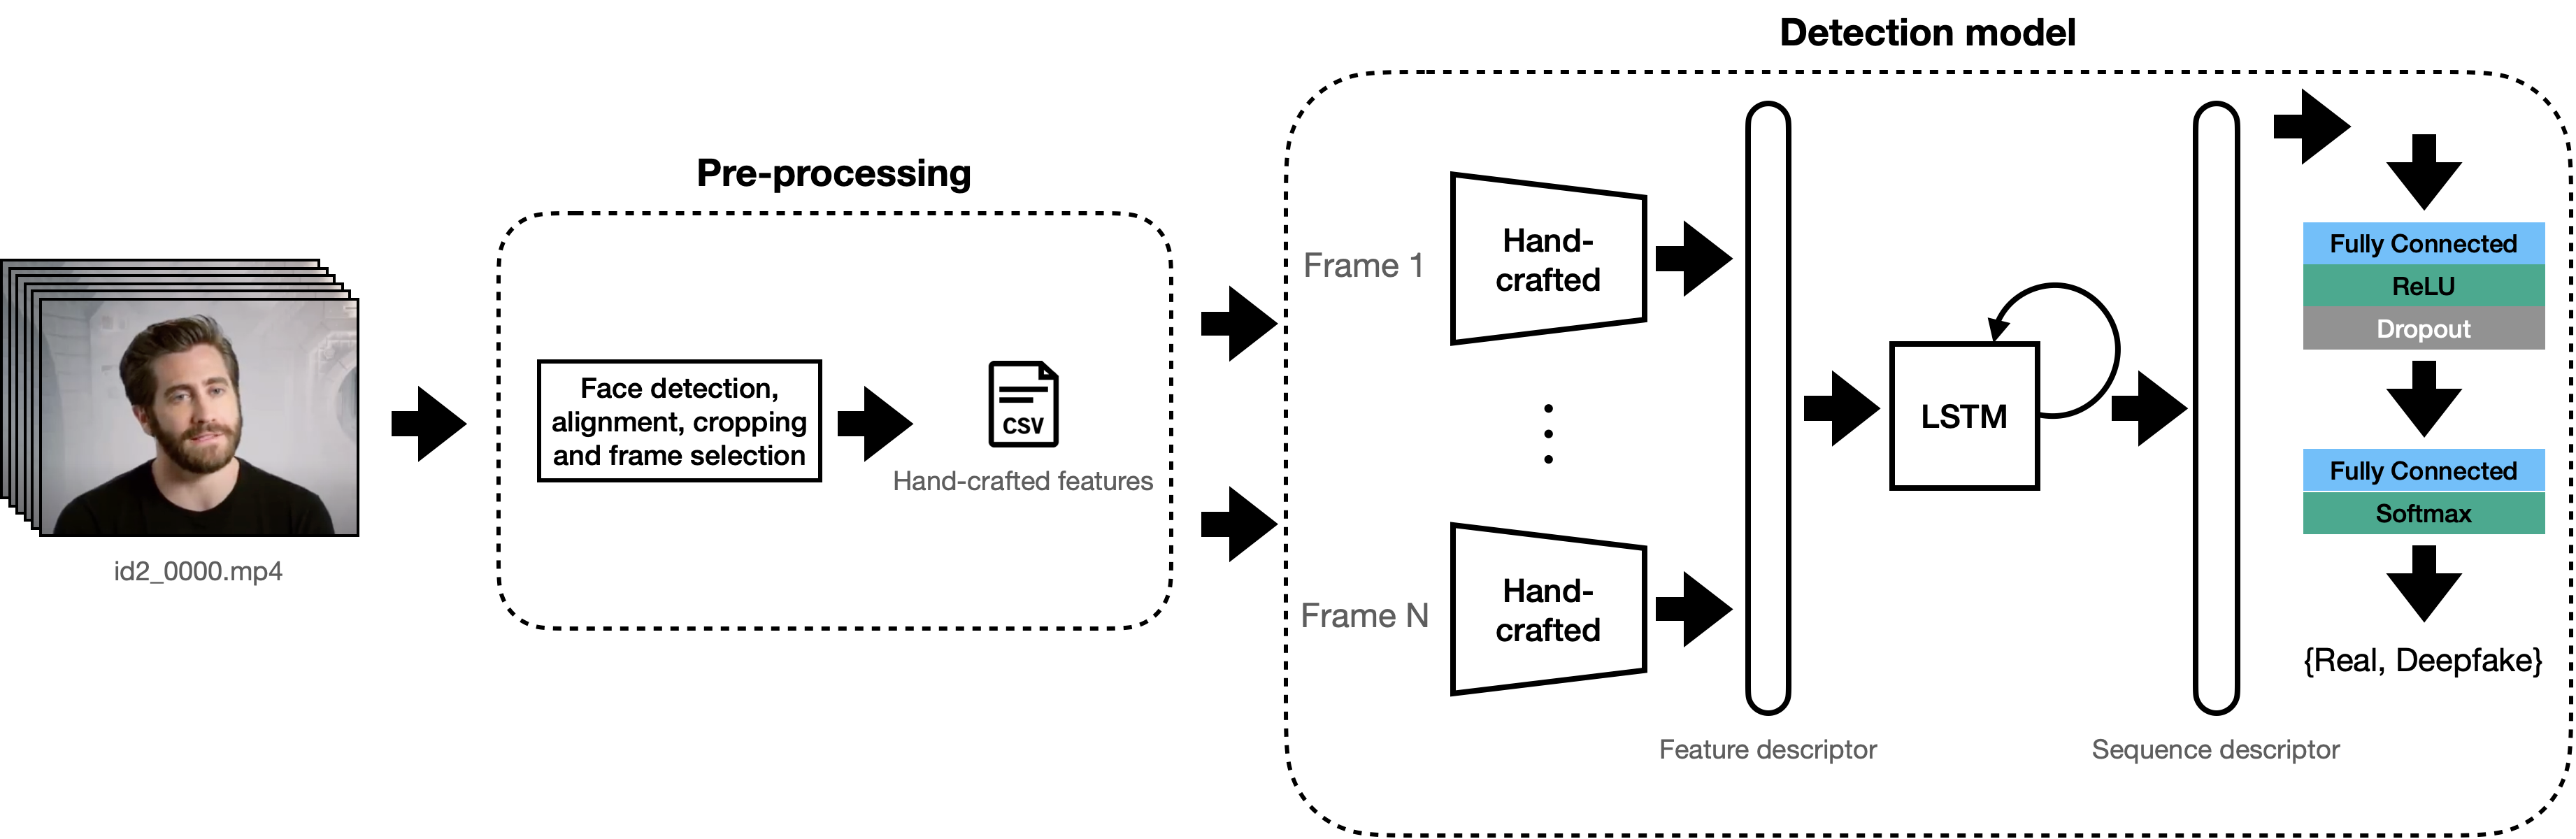

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.utils import to_categorical, plot_model
from keras import layers, models, losses, optimizers, metrics
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2, glob, os, time, pickle, sys
sys.path.insert(0, '/path/')

from preprocess import load_filepaths, load_batch_hand
tf.test.gpu_device_name()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


''

## 1. Load data

In [ ]:
# Load all filepaths
x_train, y_train, x_val, y_val, x_test, y_test = load_filepaths()

x_train = 820 , y_train (820, 2)
x_val = 180 , y_val (180, 2)
x_test = 160 , y_test (160, 2)


## 2. Define model: Hand-Crafted + LSTM

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input hand (InputLayer)      [(None, 5, 84)]           0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 512)               1222656   
_________________________________________________________________
Dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
Dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 2)                 514       
Total params: 1,354,498
Trainable params: 1,354,498
Non-trainable params: 0
_________________________________________________________________


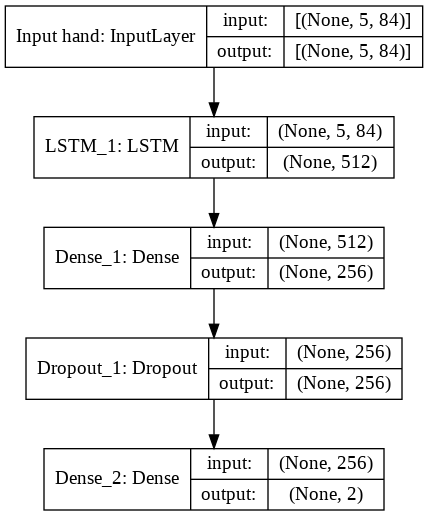

In [ ]:
# Define proposed model here
def hand_model(n_frames):
  # Define first part model: CNN + hand-crafted features model
  feats_input = layers.Input(shape=(n_frames, 84), name='Input hand')

  # Define final model on top of deep and hand-crafted features
  final = layers.LSTM(512, name='LSTM_1')(feats_input)
  final = layers.Dense(256, activation='relu', name='Dense_1')(final)
  final = layers.Dropout(0.5, name='Dropout_1')(final)
  output = layers.Dense(2, activation='softmax', name='Dense_2')(final)

  model = models.Model(inputs=feats_input, outputs=output)

  return model

model = hand_model(n_frames=5)
model.summary()
plot_model(model, 'handcrafted_model.png', show_shapes=True, show_layer_names=True)

## 3. Train the model

In [ ]:
# Speed up the training step with tf.function: https://keras.io/guides/writing_a_training_loop_from_scratch/
@tf.function
def train_step(x, y, model, loss_fn, optimizer, train_acc_metric, train_auc_metric):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss_value = loss_fn(y, y_pred)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, y_pred)
    train_auc_metric.update_state(y, y_pred)
    return loss_value

@tf.function
def val_step(x, y, model, loss_fn, val_acc_metric, val_auc_metric):
    y_pred = model(x, training=False)
    loss_value = loss_fn(y, y_pred)
    val_acc_metric.update_state(y, y_pred)
    val_auc_metric.update_state(y, y_pred)
    return loss_value

def train_model(model, x_train, y_train, x_val, y_val, batch_size, num_epochs, learning_rate=0.00001, n_frames=5, equal_interval=0, experiment='test'):
  print("[INFO] Training...")
  total_time = time.time()

  # Define loss function and optimzer, and metrics
  loss_fn = losses.CategoricalCrossentropy(from_logits=True)
  optimizer = optimizers.Adam(lr=learning_rate)
  train_acc_metric = metrics.CategoricalAccuracy()
  train_auc_metric = metrics.AUC()
  val_acc_metric = metrics.CategoricalAccuracy()
  val_auc_metric = metrics.AUC()

  train_loss = []
  train_accs = []
  train_aucs = []
  val_loss = []
  val_accs = []
  val_aucs = []

  # Create indices of x_train list to loop over
  train_batch_indices = list(range(len(x_train)//batch_size))

  # Create indices of x_val list to loop over
  val_batch_indices = list(range(len(x_val)//batch_size))

  print('[INFO] \tEpoch \tBatch \t\tLoss')
  # Looping over all data and train model
  for epoch in range(num_epochs):
    start_time = time.time()

    ##### TRAINING LOOP #####
    for b_idx in train_batch_indices:
      # Create training batch
      batch_start = b_idx * batch_size # 0*64
      batch_end = (b_idx + 1) * batch_size # 1*64

      # Create databatch with filepaths
      x_batch_train_filenames = x_train[batch_start : batch_end]
      y_batch_train = y_train[batch_start : batch_end]
      
      # Load actual hand-crafted features and aligned images for cnn
      x_batch_train_hand = load_batch_hand(x_batch_train_filenames, y_batch_train, n_frames=n_frames, equal_interval=equal_interval)
      
      # Use train_step function to speed up process
      loss_value = train_step(x_batch_train_hand, y_batch_train, model, loss_fn, optimizer, train_acc_metric, train_auc_metric)

      print('[INFO] \t{} \t{}/{} \t\t{:.4f}'.format(epoch+1, b_idx+1, len(train_batch_indices), loss_value))

    # Add training loss and accuracy at the end of each epoch to array and reset training metrics
    train_loss.append(loss_value.numpy())
    train_accs.append(train_acc_metric.result().numpy())
    train_aucs.append(train_auc_metric.result().numpy())
    train_acc_metric.reset_states()
    train_auc_metric.reset_states()
    print('[INFO] Training accuracy over epoch {}: {:.4f}'.format(epoch+1, train_accs[-1]))

    ##### VALIDATION LOOP #####
    for b_idx in val_batch_indices:
      # Create validation batch
      batch_start = b_idx * batch_size
      batch_end = (b_idx + 1) * batch_size
      x_batch_val_filenames = x_val[batch_start : batch_end]
      y_batch_val = y_val[batch_start : batch_end]

      # Load validation data for batch
      x_batch_val_hand = load_batch_hand(x_batch_val_filenames, y_batch_val, n_frames=n_frames, equal_interval=equal_interval)

      # Compute loss value through val_step function
      loss_value = val_step(x_batch_val_hand, y_batch_val, model, loss_fn, val_acc_metric, val_auc_metric)

    # Add validation loss and accuracy at the end of each epoch to array and reset validation metrics
    val_loss.append(loss_value.numpy())
    val_accs.append(val_acc_metric.result().numpy())
    val_aucs.append(val_auc_metric.result().numpy())
    val_acc_metric.reset_states()
    val_auc_metric.reset_states()
    print('[INFO] Validation accuracy over epoch {}: {:.4f}'.format(epoch+1, val_accs[-1]))
    
    # Check every 10 epochs the model and save model and weights
    if (epoch+1) % 10 == 0:
      model.save(f'/path/tmp/results_ex{experiment}_model.h5')
      print('[INFO] Model and model weights are saved')

    print('[INFO] Time taken for epoch {}: {:.2f} minutes'.format(epoch+1, (time.time() - start_time)/60 ))

  print('[INFO] Total execution time is {:.2f} hours'.format( (time.time() - total_time)/60/60 ))

  return train_loss, train_accs, train_aucs, val_loss, val_accs, val_aucs, model

In [ ]:
# Parameters
BATCH_SIZE = 16
NUM_EPOCHS = 20
N_FRAMES = 10
EQUAL_INTERVAL = 15
EXPERIMENT = '14.1'
LEARNING_RATE = 0.00001

# Construct model and train
model = hand_model(n_frames=N_FRAMES)

train_loss, train_accs, train_aucs, val_loss, val_accs, val_aucs, model = train_model(model, x_train, y_train, x_val, y_val, batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)

## 4. Visualize and save results

In [ ]:
# Save results in pickle file
results = [train_loss, train_accs, train_aucs, val_loss, val_accs, val_aucs]
with open(f'/path/tmp/results_ex{EXPERIMENT}.pickle', 'wb') as f:
  pickle.dump(results, f)

# Visualize and save plot
plt.figure(figsize=(18,4))
plt.suptitle(f'Results of experiment {EXPERIMENT}', fontsize=16)

plt.subplot(1,3,1)
plt.title('Training and Validation accuracy')
plt.plot(train_accs)
plt.plot(val_accs)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

plt.subplot(1,3,2)
plt.title('Training and Validation Loss')
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])

plt.subplot(1,3,3)
plt.title('Training and Validation AUC')
plt.plot(train_aucs)
plt.plot(val_aucs)
plt.xlabel('Epoch')
plt.ylabel('Area Under the Curve')
plt.legend(['Training AUC', 'Validation AUC'])

plt.savefig(f'/path/tmp/results_ex{EXPERIMENT}.png')
plt.show()

## 5. Test model's performance

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sn

def evaluate_model(model, x_test, y_test, batch_size, n_frames=5, equal_interval=0, experiment='test'):
  start_time = time.time()

  # Define evaluation metrics
  test_acc_metric = metrics.CategoricalAccuracy()
  test_auc_metric = metrics.AUC()

  # Create indices of x_test list to loop over
  test_batch_indices = list(range(len(x_test)//batch_size))
  predictions = []
  probas = []

  ##### TEST LOOP #####
  for b_idx in test_batch_indices:
    # Create test batch
    batch_start = b_idx * batch_size
    batch_end = (b_idx + 1) * batch_size
    x_batch_test_filenames = x_test[batch_start : batch_end]
    y_batch_test = y_test[batch_start : batch_end]

    # Load test data for batch
    x_batch_test_hand = load_batch_hand(x_batch_test_filenames, y_batch_test, n_frames=n_frames, equal_interval=equal_interval)

    # Compute predictions, and onvert one-hot encoded data back to 0 (fake) and 1 (real)
    y_prob = model(x_batch_test_hand, training=False)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y_batch_test, axis=1)
    probas.append(y_prob)
    predictions.append(y_pred)
    test_acc_metric.update_state(y_batch_test, y_prob)
    test_auc_metric.update_state(y_batch_test, y_prob)
    print(f'[INFO] {b_idx+1} / {len(test_batch_indices)}')

  test_acc = round(test_acc_metric.result().numpy(), 3)
  test_auc = round(test_auc_metric.result().numpy(), 3)

  # Calculate confusion matrix
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.array(predictions).flatten())
  tn = cm[0][0]
  fp = cm[0][1]
  fn = cm[1][0]
  tp = cm[1][1]

  print('Confusion matrix', cm)

  # Calculate false postive rates and true positive rates
  probas = np.array(probas).reshape(len(x_test), 2)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test[:, 1], probas)

  print()
  print('Performances on test dataset')
  print(f'Accuracy: {test_acc}')
  print(f'AUC: {test_auc}')
  print(f'TP: {tp}')
  print(f'FP: {fp}')
  print(f'TN: {tn}')  
  print(f'FN: {fn}')

  print()

  print('Correctly Detected Deepfakes (True Negatives): ', tn)
  print('Deepfake Videos Incorrectly Detected (False Positives): ', fp)
  print('Deepfake Videos Missed (False Negatives): ', fn)
  print('Deepfake Videos Detected (True Positives): ', tp)
  print('Total Deepfake Videos: ', tn+fp+fn+tp)
  print()
  print('Time taken: {:.4f} seconds'.format((time.time() - start_time)))

  return test_acc, test_auc, predictions, tp, fp, tn, fn, fpr, tpr, cm

x_train = 820 , y_train (820, 2)
x_val = 180 , y_val (180, 2)
x_test = 160 , y_test (160, 2)
Loaded in model baseline 11.1
[INFO] 1 / 10
[INFO] 2 / 10
[INFO] 3 / 10
[INFO] 4 / 10
[INFO] 5 / 10
[INFO] 6 / 10
[INFO] 7 / 10
[INFO] 8 / 10
[INFO] 9 / 10
[INFO] 10 / 10
Confusion matrix [[80  0]
 [80  0]]

Performances on test dataset
Accuracy: 0.5
AUC: 0.5
TP: 0
FP: 0
TN: 80
FN: 80

Correctly Detected Deepfakes (True Negatives):  80
Deepfake Videos Incorrectly Detected (False Positives):  0
Deepfake Videos Missed (False Negatives):  80
Deepfake Videos Detected (True Positives):  0
Total Deepfake Videos:  160

Time taken: 44.6144 seconds
Loaded in model baseline 12.1
[INFO] 1 / 10
[INFO] 2 / 10
[INFO] 3 / 10
[INFO] 4 / 10
[INFO] 5 / 10
[INFO] 6 / 10
[INFO] 7 / 10
[INFO] 8 / 10
[INFO] 9 / 10
[INFO] 10 / 10
Confusion matrix [[80  0]
 [80  0]]

Performances on test dataset
Accuracy: 0.5
AUC: 0.5
TP: 0
FP: 0
TN: 80
FN: 80

Correctly Detected Deepfakes (True Negatives):  80
Deepfake Videos Incorre

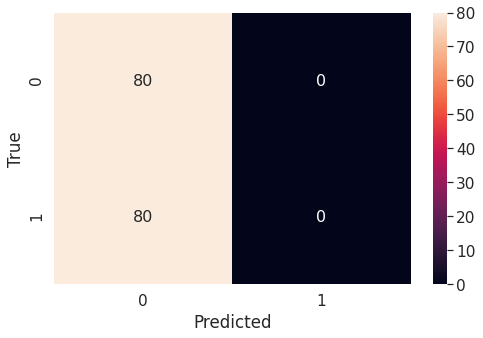

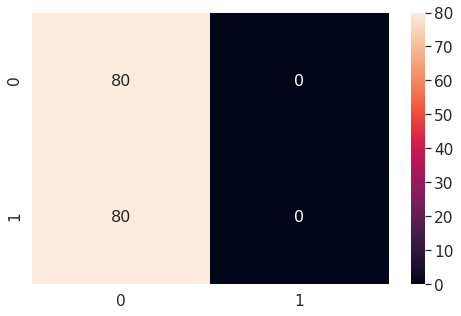

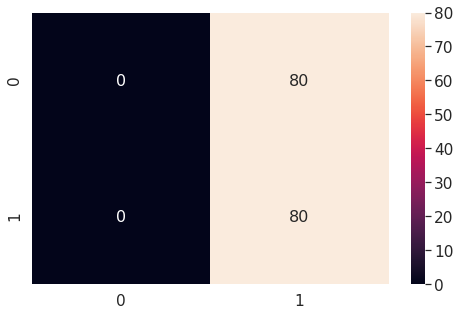

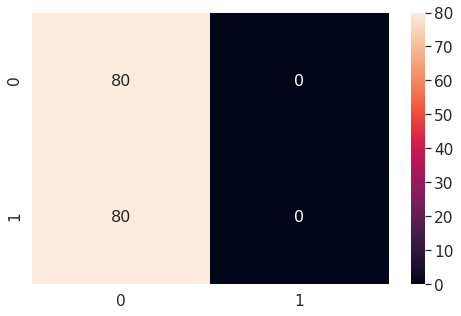

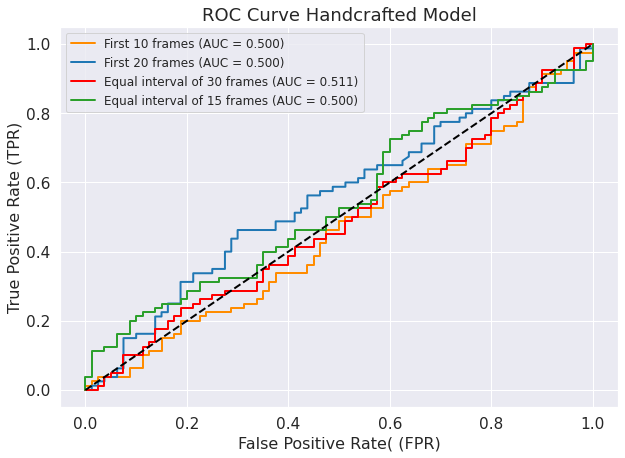

In [ ]:
# Load data filepaths
x_train, y_train, x_val, y_val, x_test, y_test = load_filepaths()
#x_test = x_test[:64]
#y_test = y_test[:64]

BATCH_SIZE = 16
handcrafted_models = ['11.1', '12.1', '14.1', '15.1']

for EXPERIMENT in handcrafted_models:
  model = models.load_model(f'/path/tmp/results_ex{EXPERIMENT}_model.h5')
  print(f'Loaded in model baseline {EXPERIMENT}')

  if EXPERIMENT == '11.1':
    N_FRAMES = 10
    EQUAL_INTERVAL = 0
    acc_10, auc_10, pred_10, tp_10, fp_10, tn_10, fn_10, fpr_10, tpr_10, cm = evaluate_model(model, x_test, y_test, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)
    plt.figure(figsize=(8,5))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(cm, annot=True, annot_kws={"size": 16}, cbar=True) # font size
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'/path/plots/CM_handcrafted_model{EXPERIMENT}.png')

  if EXPERIMENT == '12.1':
    N_FRAMES = 20
    EQUAL_INTERVAL = 0
    acc_20, auc_20, pred_20, tp_20, fp_20, tn_20, fn_20, fpr_20, tpr_20, cm = evaluate_model(model, x_test, y_test, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)
    plt.figure(figsize=(8,5))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(cm, annot=True, annot_kws={"size": 16}, cbar=True) # font size
    plt.savefig(f'/path/plots/CM_handcrafted_model{EXPERIMENT}.png')

  if EXPERIMENT == '14.1':
    N_FRAMES = 10
    EQUAL_INTERVAL = 15
    acc_30, auc_30, pred_30, tp_30, fp_30, tn_30, fn_30, fpr_30, tpr_30, cm = evaluate_model(model, x_test, y_test, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)
    plt.figure(figsize=(8,5))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(cm, annot=True, annot_kws={"size": 16}, cbar=True) # font size
    plt.savefig(f'/path/plots/CM_handcrafted_model{EXPERIMENT}.png')

  if EXPERIMENT == '15.1':
    N_FRAMES = 5
    EQUAL_INTERVAL = 30
    acc_15, auc_15, pred_15, tp_15, fp_15, tn_15, fn_15, fpr_15, tpr_15, cm = evaluate_model(model, x_test, y_test, batch_size=BATCH_SIZE, n_frames=N_FRAMES, equal_interval=EQUAL_INTERVAL, experiment=EXPERIMENT)
    plt.figure(figsize=(8,5))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(cm, annot=True, annot_kws={"size": 16}, cbar=True) # font size
    plt.savefig(f'/path/plots/CM_handcrafted_model{EXPERIMENT}.png')

plt.figure(figsize=(10,7))
plt.plot(fpr_10, tpr_10, label='First 10 frames (AUC = {:.3f})'.format(auc_10), linewidth=2, color='darkorange')
plt.plot(fpr_20, tpr_20, label='First 20 frames (AUC = {:.3f})'.format(auc_20), linewidth=2, color='tab:blue')
plt.plot(fpr_30, tpr_30, label='Equal interval of 30 frames (AUC = {:.3f})'.format(auc_30), linewidth=2, color='red')
plt.plot(fpr_15, tpr_15, label='Equal interval of 15 frames (AUC = {:.3f})'.format(auc_15), linewidth=2, color='tab:green')
plt.plot(np.linspace(0, 1, 100),
        np.linspace(0, 1, 100),
        linestyle='--', linewidth=2, color='black')
plt.title('ROC Curve Handcrafted Model', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=16)
plt.xlabel('False Positive Rate( (FPR)', fontsize=16)
plt.legend(fontsize=12)
plt.savefig('/path/plots/AUC_plot_handcrafted_model')
plt.show()